In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

uploaded = files.upload()

Saving Alpha synuclein Log transformed.xlsx to Alpha synuclein Log transformed.xlsx


Once your file is uploaded, you can load it into a pandas DataFrame. Please replace `"your_file_name.csv"` with the actual name of the file you uploaded.

In [5]:
import pandas as pd
import io
import numpy as np

# Assuming you uploaded a single CSV file, get its name
file_name = next(iter(uploaded))

# Use pd.read_excel for .xlsx files
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert all suitable columns to numeric
for col in df.columns:
    if col != 'Gene ID': # Assuming 'Gene ID' is an identifier and should not be converted
        df[col] = df[col].replace('#VALUE!', np.nan)
        # Attempt to convert to numeric, coercing errors will turn invalid parsing into NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"DataFrame '{file_name}' loaded successfully. Here are the first 5 rows:")
display(df.head())

DataFrame 'Alpha synuclein Log transformed.xlsx' loaded successfully. Here are the first 5 rows:


,Gene ID,WT_D1_1,WT_D1_2,WT_D10_1,WT_D10_2,WT_D30_1,WT_D30_2,A30P_D1_1,A30P_D1_2,A30P_D10_1,A30P_D10_2,A53T_D1_1,A53T_D1_2,A53T_D10_1,A53T_D10_2,A53T_D30_1,A53T_D30_2
0,NaN,-1.144903,NaN,NaN,NaN,-0.646406,-1.390510,-0.630707,-1.048800,-1.363457,-1.449612,-0.991943,NaN,-1.464066,-1.939095,NaN,-2.285038
1,dnc,-1.258322,-1.648779,-1.381122,-2.117787,-2.122366,-2.448194,-1.834030,-2.350706,-1.820311,-2.124629,-1.187871,NaN,-2.388733,-2.078198,NaN,-2.181804
2,NaN,NaN,NaN,-0.444125,-1.867121,NaN,-0.189960,-1.984845,NaN,-2.193833,-1.280685,-1.456999,NaN,-2.380521,-2.714633,-2.430820,-2.072483
3,Marf,-0.954641,-1.284686,-1.517296,-2.158816,-0.537613,-0.992833,-1.037977,-1.583549,-1.725899,-2.042992,-0.804048,-1.256528,-1.649095,-1.301017,NaN,-1.980796
4,Rh4,NaN,-0.369930,NaN,NaN,NaN,-3.020692,0.648926,-1.958981,-3.534981,0.174406,NaN,NaN,-0.967448,-1.357825,-0.627471,-1.930765


In [12]:
# Step 2. Define groups based on column names and prepare data

# Identify potential group names from column headers and map to standard names
group_definitions = {
    'WT': [],      # This will store WT_D... columns, representing the control group
    'A30P': [], # This will store A30P_D... columns
    'A53T': []  # This will store A53T_D... columns
}

for col in df.columns:
    if col == 'Gene ID':
        continue
    # Correctly identify groups based on column prefixes (e.g., 'WT_', 'A30P_', 'A53T_')
    if col.startswith('WT_'):
        group_definitions['WT'].append(col)
    elif col.startswith('A30P_'):
        group_definitions['A30P'].append(col)
    elif col.startswith('A53T_'):
        group_definitions['A53T'].append(col)

# Prepare data for control and treatment groups
control = pd.Series(dtype=float) # Initialize as empty Series of float
# Access 'WT' key which is now correctly defined in group_definitions
if group_definitions['WT']:
    control = pd.concat([df[col] for col in group_definitions['WT']]).dropna()

if control.empty:
    print("Warning: Control group 'WT' data is empty or not found. Please check column names and group mapping.")

treatments_data = {} # Dictionary to hold series for each treatment group
treatments = [] # List of treatment names for the loop, like ["A30P", "A53T"]

for tr_key in ['A30P', 'A53T']: # Maintain order for consistency. These keys now match group_definitions
    # Check if the key exists in group_definitions before accessing it
    if tr_key in group_definitions and group_definitions[tr_key]:
        tr_data = pd.concat([df[col] for col in group_definitions[tr_key]]).dropna()
        if not tr_data.empty:
            treatments_data[tr_key] = tr_data
            treatments.append(tr_key)
        else:
            print(f"Warning: Treatment group '{tr_key}' has no valid data points after dropping NaNs.")
    else:
        print(f"Warning: No columns found for treatment group '{tr_key}'.")

print(f"Control group ('WT') data points: {len(control)}")
for tr_name in treatments:
    print(f"Treatment group ('{tr_name}') data points: {len(treatments_data[tr_name])}")

Control group ('WT') data points: 14084
Treatment group ('A30P') data points: 9856
Treatment group ('A53T') data points: 13338


In [14]:
# Step 3. Welch’s t-tests (each treatment vs control, and between treatments)
pvals, tstats, comparisons = [], [], []

# Comparisons vs Control
for tr in treatments: # `treatments` is now ["A30P", "A53T"]
    group = treatments_data[tr] # Access data from the treatments_data dictionary
    tstat, pval = stats.ttest_ind(control, group, equal_var=False)
    pvals.append(pval)
    tstats.append(tstat)
    comparisons.append(f"{tr} vs WT")

# Additional comparison: A30P vs A53T
if 'A30P' in treatments_data and 'A53T' in treatments_data:
    tstat_mutant_vs_mutant, pval_mutant_vs_mutant = stats.ttest_ind(treatments_data['A30P'], treatments_data['A53T'], equal_var=False)
    pvals.append(pval_mutant_vs_mutant)
    tstats.append(tstat_mutant_vs_mutant)
    comparisons.append("A30P vs A53T")

# Step 4. Holm correction
reject, pvals_corr, _, _ = multipletests(pvals, method='holm')

# Step 5. Summarize results
results = pd.DataFrame({
    "Comparison": comparisons,
    "t-statistic": tstats,
    "Raw p-value": pvals,
    "Holm-corrected p-value": pvals_corr,
    "Significant": reject
})
print("\nDunnett-style (Welch + Holm) results:\n")
print(results.to_string(index=False))


Dunnett-style (Welch + Holm) results:

  Comparison  t-statistic  Raw p-value  Holm-corrected p-value  Significant
  A30P vs WT     3.128740     0.001758                0.005274         True
  A53T vs WT     1.216926     0.223643                0.223643        False
A30P vs A53T    -1.992513     0.046328                0.092655        False


Plot saved as 'expression_levels_plot.pdf'


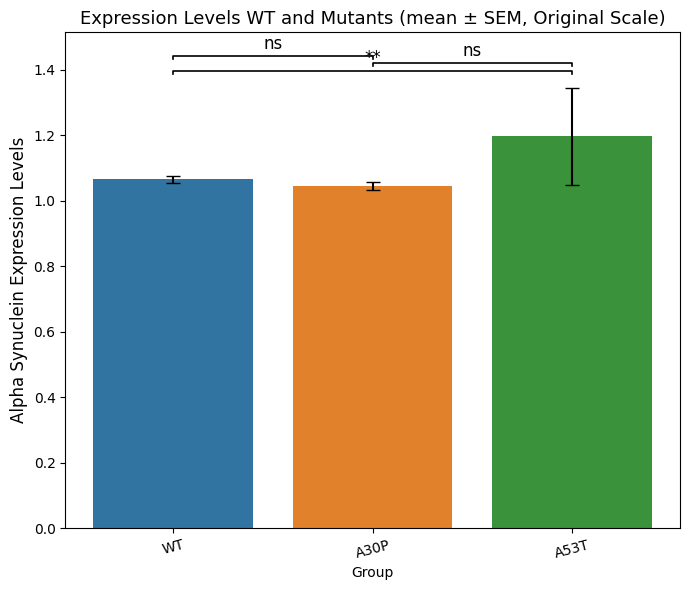

In [29]:
# Step 6. Compute summary stats for plotting
# Create a DataFrame for summary statistics using 'control' and 'treatments_data'
all_data = {
    "WT": np.exp2(control), # Apply inverse log2 transform
}
for tr_name in treatments:
    all_data[tr_name] = np.exp2(treatments_data[tr_name]) # Apply inverse log2 transform

# Convert dictionary of series into a long format DataFrame for easy summary calculation
summary_df_for_agg = pd.DataFrame([(group, val) for group, series in all_data.items() for val in series],
                                  columns=['Group', 'Expression_Value'])

synonym_map = {
    'Alpha A30P': 'A30P',
    'Alpha A53T': 'A53T'
}
summary_df_for_agg['Group'] = summary_df_for_agg['Group'].replace(synonym_map)

# Update the 'treatments' list to reflect the new names for ordering
treatments_updated = [synonym_map.get(tr, tr) for tr in treatments]

summary = summary_df_for_agg.groupby("Group").agg(
    mean=("Expression_Value", "mean"),
    sem=("Expression_Value", lambda x: stats.sem(x, nan_policy='omit')) # Use scipy.stats.sem and omit NaNs
).reset_index()

# Ensure the summary order matches the comparison order for plotting
# Reorder summary to have WT first, then treatments in the order they appear in 'treatments' list
ordered_groups = ['WT'] + treatments_updated
summary['Group'] = pd.Categorical(summary['Group'], categories=ordered_groups, ordered=True)
summary = summary.sort_values('Group')


# Step 7. Plot mean ± SEM
plt.figure(figsize=(7,6)) # Slightly larger figure for better readability
sns.barplot(
    data=summary,
    x="Group", y="mean",
    hue="Group", dodge=False, legend=False,
    palette=["#1f77b4", "#ff7f0e", "#2ca02c"], # Updated distinct colors
    errorbar=None
)

# Add manual SEM bars
x_positions = np.arange(len(summary))
plt.errorbar(
    x=x_positions, y=summary["mean"], yerr=summary["sem"],
    fmt='none', ecolor='black', capsize=5, lw=1.5
)

plt.ylabel("Alpha Synuclein Expression Levels", fontsize=12) # Updated y-axis title
plt.title("Expression Levels WT and Mutants (mean ± SEM, Original Scale)", fontsize=13) # Generalizing title
plt.xticks(ticks=x_positions, labels=summary["Group"], rotation=15)

# Step 8. Add significance markers ===
y_max_plot = summary["mean"].max() + summary["sem"].max() # Find max y-value for positioning
# Adjust y and h for the new scale; make them relative to the data range for better visualization
y_range = summary["mean"].max() - summary["mean"].min() + summary["sem"].max()
y_offset = y_range * 0.15 # Increased offset for more space
h_height = y_range * 0.03 # Increased bar height
y, h = y_max_plot + y_offset, h_height
y_increment = h * 2.5 # Increased increment for each significance bar

# Adjust the x-positions for the significance bars to compare treatments to WT
# The x-positions in the bar plot correspond to the order of groups in the 'summary' DataFrame
wt_index = summary[summary['Group'] == 'WT'].index[0]
alpha_a30p_index = summary[summary['Group'] == 'A30P'].index[0]
alpha_a53t_index = summary[summary['Group'] == 'A53T'].index[0]

# Define all comparison pairs for plotting
plotting_comparison_indices = [
    (wt_index, alpha_a30p_index),  # A30P vs WT
    (wt_index, alpha_a53t_index),  # A53T vs WT
    (alpha_a30p_index, alpha_a53t_index) # A30P vs A53T
]

# Update comparisons list as well, to reflect the new group names if they were changed earlier.
comparisons_for_plot = [
    "A30P vs WT",
    "A53T vs WT",
    "A30P vs A53T"
]

for i, (p, sig) in enumerate(zip(pvals_corr, reject)):
    x1, x2 = plotting_comparison_indices[i]
    plot_y = y + i * y_increment # Offset subsequent bars
    plt.plot([x1, x1, x2, x2], [plot_y, plot_y+h, plot_y+h, plot_y], lw=1.2, color='black')
    if sig:
        if p < 0.001:
            stars = "***"
        elif p < 0.01:
            stars = "**"
        elif p < 0.05:
            stars = "*"
        else:
            stars = "ns"
            # Add "ns" for non-significant
    else:
        stars = "ns" # Explicitly mark non-significant

    plt.text((x1 + x2) / 2, plot_y + h + 0.01, stars, ha='center', va='bottom', fontsize=12) # Adjusted font size for stars

plt.tight_layout()
plt.savefig('expression_levels_plot.pdf') # Save before showing
print("Plot saved as 'expression_levels_plot.pdf'")
plt.show()